In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, BisectingKMeans, Birch, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
data_dir = os.getcwd()[:-27] +'data\\'

In [3]:
# To Load csv locally:

data_dir = os.getcwd()[:-27] +'data\\'
os.chdir(data_dir)
file_name = 'processed_data.csv'

In [4]:
# Read the data
data = pd.read_csv(file_name)
data.head()

,acousticness,artist_name,danceability,duration_m,energy,explicit,instrumentalness,key,liveness,loudness,mode,month,popularity,preview_url,speechiness,tempo,track_id,valence,year
0,0.00126,Headhunterz,0.355,2.943667,0.881,f,0.000002,9,0.0694,-3.962,1,7,26.0,https://p.scdn.co/mp3-preview/4229181352cb0c16...,0.1800,75,7o7Qx3kulN6A0uOaAPf5Vz,0.190,2022
1,0.18700,Headhunterz,0.552,3.902767,0.829,f,0.000054,6,0.2830,-4.988,0,9,51.0,https://p.scdn.co/mp3-preview/4d5c7620737fbd8e...,0.0845,150,0zolxiS5uiL5towOJrsJi4,0.367,2019
2,0.02730,Crossing Colors,0.839,5.818183,0.721,f,0.900000,9,0.0667,-7.721,0,7,9.0,https://p.scdn.co/mp3-preview/d8e54d5d229948b9...,0.0477,110,6AJ1Rk1khe1egig27nXImU,0.768,2018
3,0.01430,Brennan Heart,0.543,3.520000,0.827,f,0.000000,1,0.0842,-3.585,0,5,46.0,https://p.scdn.co/mp3-preview/a8e60e3bd2defda5...,0.0350,150,2KM4KCDbbfOvQ5cgWADd0Z,0.123,2021
4,0.01080,Brennan Heart,0.623,3.946667,0.832,f,0.000000,1,0.0487,-3.348,0,5,17.0,https://p.scdn.co/mp3-preview/758c6b9f2ff9b87b...,0.0566,150,7t2gGVF4Q7QnFM9dt9F0qE,0.439,2021


# Key Features

Based on Correlation-based Feature Selection **instrumentalness, acousticness, danceability** and **energy** are the 4 most important features.


_From_ [EDA_Final.ipynb: _5.Feature Selection_](https://github.com/dmml-heriot-watt/group-coursework-machine-learners/blob/main/notebooks/EDA/EDA_Final.ipynb)

We examine the probability density distribution of each of these and how they correlate to each other.

In [5]:
model_columns = ['acousticness', 'instrumentalness', 'danceability', 'energy'] 
model_data = data[model_columns].copy()
model_data.describe()

,acousticness,instrumentalness,danceability,energy
count,451325.000000,451325.000000,451325.000000,451325.000000
mean,0.083358,0.589289,0.686867,0.747856
std,0.184691,0.355736,0.140169,0.189761
min,0.000000,0.000000,0.023400,0.000020
25%,0.001040,0.210000,0.613000,0.632000
50%,0.007770,0.783000,0.715000,0.785000
75%,0.056200,0.880000,0.794000,0.903000
max,0.996000,0.999000,0.995000,1.000000


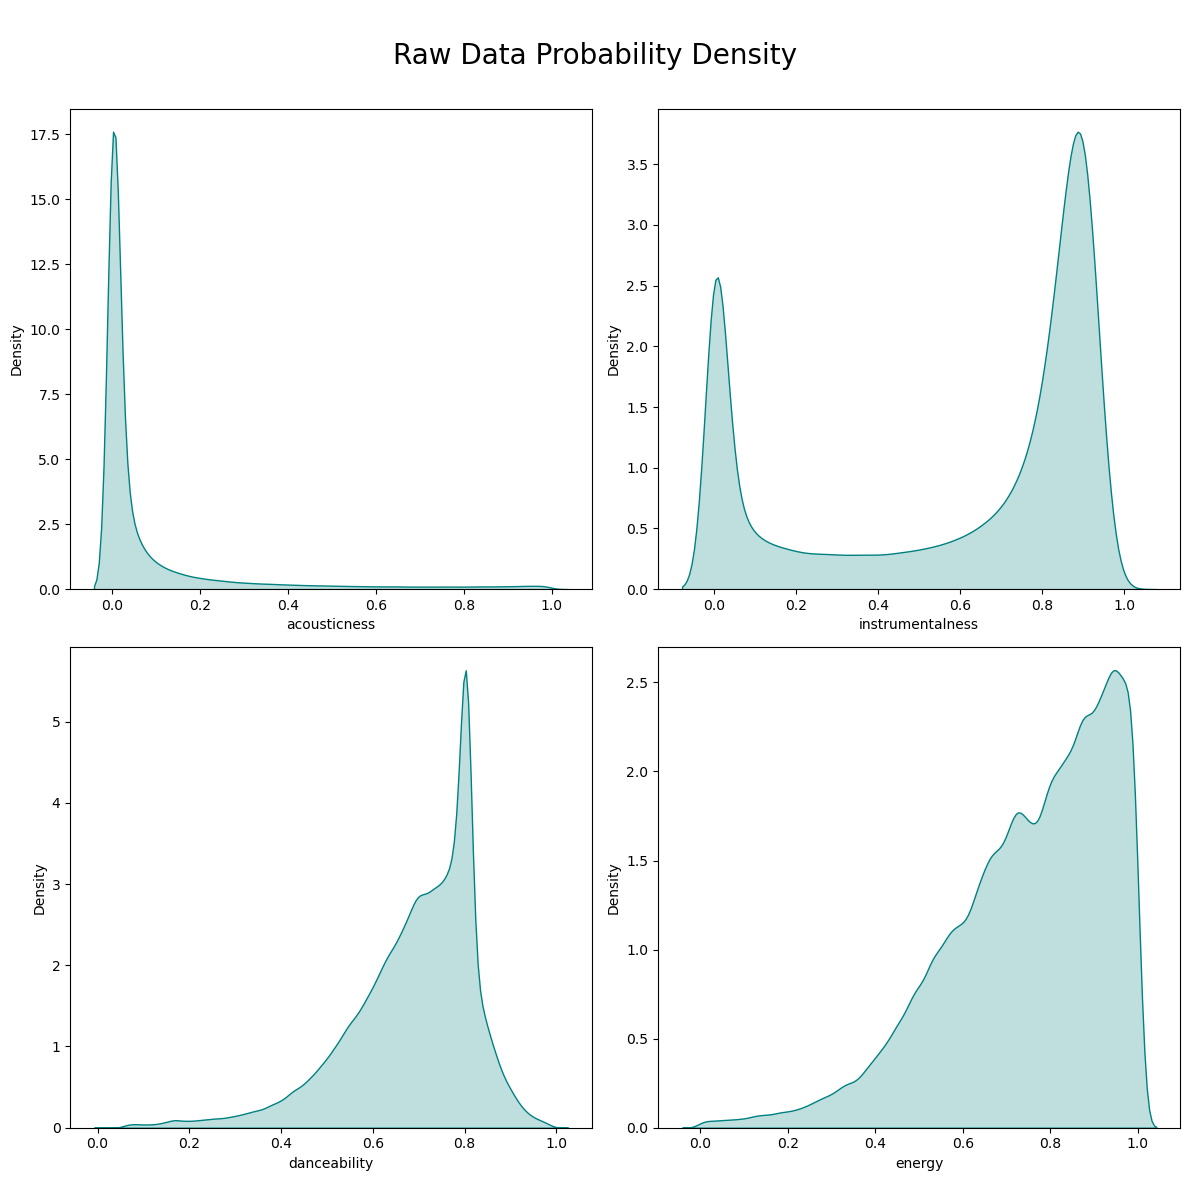

In [6]:
f, axes = plt.subplots(2, 2, figsize=(12, 12))
f.suptitle("\nRaw Data Probability Density\n", fontsize=20)
sns.kdeplot(data["acousticness"] , color="teal", fill=True, ax=axes[0, 0])
sns.kdeplot(data["instrumentalness"] , color="teal", fill=True, ax=axes[0, 1])
sns.kdeplot(data["danceability"] , color="teal", fill=True, ax=axes[1, 0])
sns.kdeplot(data["energy"] , color="teal", fill=True, ax=axes[1, 1])

plt.tight_layout()
plt.show()

### Key Features Analysis 

We can see that every single one of the key features is heavily concetrated around a single value (with the exception of ```instrumentalness```, which is bimodal). That means that the tracks are usually:
- (```acousticness```)......... Not acoustic
- (```instrumentalness```).. Fairly well split between lyrical and instrumental
- (```danceability```)......... Very fit for dancing (in terms of tempo, rhythmm, beat)
- (```energy```)................... Very high energy (intense, fast, noisy, loud)

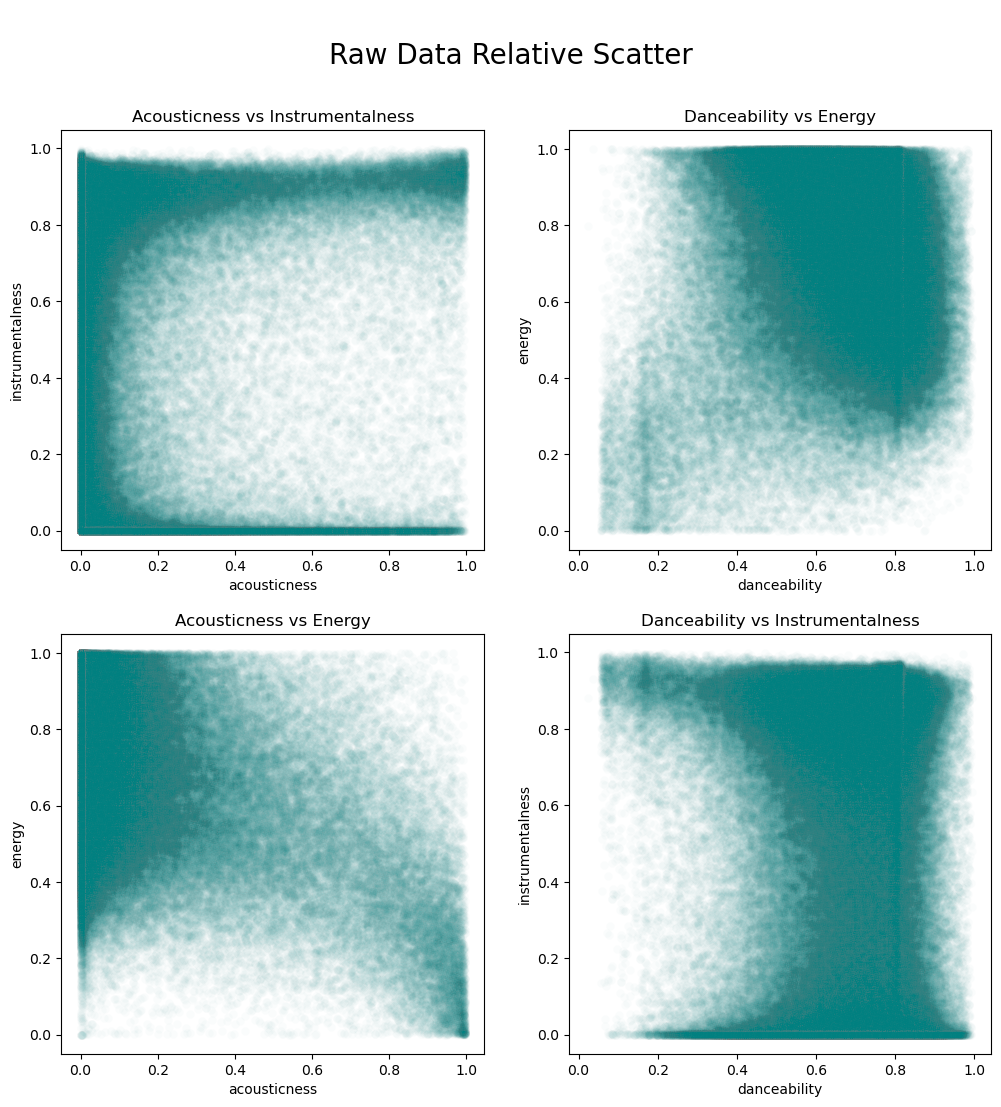

In [7]:
# Visualize the clusters using scatter plots
f, axes = plt.subplots(2, 2, figsize=(12, 12))
alpha = 0.02
color = 'teal'

f.suptitle("\nRaw Data Relative Scatter", fontsize=20)
axes[0,0].set_title('Acousticness vs Instrumentalness')
axes[0,1].set_title('Danceability vs Energy')
axes[1,0].set_title('Acousticness vs Energy')
axes[1,1].set_title('Danceability vs Instrumentalness')
sns.scatterplot(x = 'acousticness', y = 'instrumentalness', data = data, alpha = alpha, color = color, ax=axes[0,0])
sns.scatterplot(x = 'danceability', y = 'energy', data = data, alpha = alpha, color = color, ax=axes[0,1])
sns.scatterplot(x = 'acousticness', y = 'energy', data = data, alpha = alpha, color = color, ax=axes[1,0])
sns.scatterplot(x = 'danceability', y = 'instrumentalness', data = data, alpha = alpha, color = color, ax=axes[1,1])
plt.show()

### Key Features Analysis 

From the scatter plots we can see no intuitive clustering, the data seems homogenous.

# K-means Clustering
Considering the large sample size we perform iterative k-means clustering to find the optimal number of clusters and evaluate using the elbow method in terms of the sample inertia*.

*_during testing the silhouette score proved to be slow (around ~50min per iteration)_

In [8]:
sse = []
k_values = range(1, 15)
start_time = datetime.now().isoformat(timespec='seconds')
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 'auto')
    kmeans.fit(model_data)
    sse.append(kmeans.inertia_)
    print('Start: ', start_time, 'clusters: ', k, datetime.now().isoformat(timespec='seconds'))

Start:  2023-11-22T18:12:58 clusters:  1 2023-11-22T18:12:59
Start:  2023-11-22T18:12:58 clusters:  2 2023-11-22T18:12:59
Start:  2023-11-22T18:12:58 clusters:  3 2023-11-22T18:12:59
Start:  2023-11-22T18:12:58 clusters:  4 2023-11-22T18:12:59
Start:  2023-11-22T18:12:58 clusters:  5 2023-11-22T18:13:00
Start:  2023-11-22T18:12:58 clusters:  6 2023-11-22T18:13:00
Start:  2023-11-22T18:12:58 clusters:  7 2023-11-22T18:13:01
Start:  2023-11-22T18:12:58 clusters:  8 2023-11-22T18:13:01
Start:  2023-11-22T18:12:58 clusters:  9 2023-11-22T18:13:02
Start:  2023-11-22T18:12:58 clusters:  10 2023-11-22T18:13:02
Start:  2023-11-22T18:12:58 clusters:  11 2023-11-22T18:13:03
Start:  2023-11-22T18:12:58 clusters:  12 2023-11-22T18:13:04
Start:  2023-11-22T18:12:58 clusters:  13 2023-11-22T18:13:05
Start:  2023-11-22T18:12:58 clusters:  14 2023-11-22T18:13:05


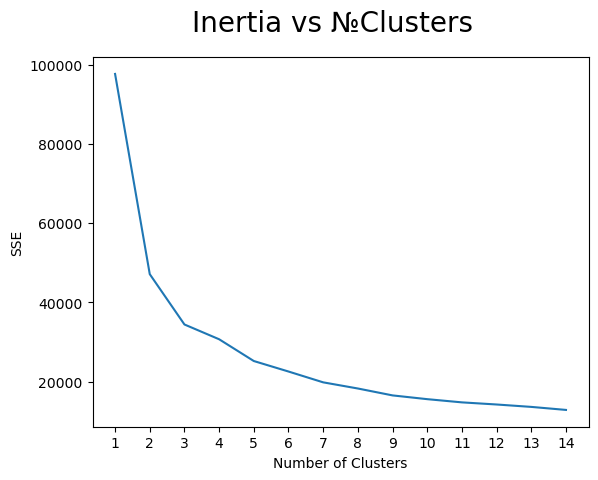

In [9]:
#visualize results
plt.suptitle("Inertia vs №Clusters", fontsize=20)
plt.plot(range(1, 15), sse)
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### K-means clustering
We can see that the optimal number of clusters is 3. 

In [10]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init = 'auto')
kmeans.fit(model_data)
print(f'K-means, k=3, Cluster size: {np.unique(kmeans.labels_, return_counts=True)[1]}')

K-means, k=3, Cluster size: [284033  26448 140844]


We know that the performance is affected by the initialization of the cetnroids, so we will see if there is change if the centroids are allocated with the default initialization of ```init='k-means++'``` or with a random ones.

In [11]:
print('k-means++ centroids')
for trial in range(0,10):
    kmeans = KMeans(n_clusters=3, random_state=42, n_init = 'auto')
    kmeans.fit(model_data)
    k_means_dbs = davies_bouldin_score(model_data, kmeans.labels_)
    k_means_chs = calinski_harabasz_score(model_data, kmeans.labels_)
    print(f'Step {trial}: Cluster size: {np.unique(kmeans.labels_, return_counts=True)[1]} \nDavies Bouldin Score: {k_means_dbs} \nCalinski-Harabasz Score: {k_means_chs}\n')

k-means++ centroids
Step 0: Cluster size: [284033  26448 140844] 
Davies Bouldin Score: 0.8167596563460061 
Calinski-Harabasz Score: 414807.4460555022

Step 1: Cluster size: [284033  26448 140844] 
Davies Bouldin Score: 0.8167596563460061 
Calinski-Harabasz Score: 414807.4460555022

Step 2: Cluster size: [284033  26448 140844] 
Davies Bouldin Score: 0.8167596563460061 
Calinski-Harabasz Score: 414807.4460555022

Step 3: Cluster size: [284033  26448 140844] 
Davies Bouldin Score: 0.8167596563460061 
Calinski-Harabasz Score: 414807.4460555022

Step 4: Cluster size: [284033  26448 140844] 
Davies Bouldin Score: 0.8167596563460061 
Calinski-Harabasz Score: 414807.4460555022

Step 5: Cluster size: [284033  26448 140844] 
Davies Bouldin Score: 0.8167596563460061 
Calinski-Harabasz Score: 414807.4460555022

Step 6: Cluster size: [284033  26448 140844] 
Davies Bouldin Score: 0.8167596563460061 
Calinski-Harabasz Score: 414807.4460555022

Step 7: Cluster size: [284033  26448 140844] 
Davies Bou

In [12]:
print('Random centroids:')
for trial in range(0,10):
    kmeans = KMeans(n_clusters=3, init='random', random_state=42, n_init='auto')
    kmeans.fit(model_data)
    k_means_dbs = davies_bouldin_score(model_data, kmeans.labels_)
    k_means_chs = calinski_harabasz_score(model_data, kmeans.labels_)
    print(f'Step {trial}: Cluster size: {np.unique(kmeans.labels_, return_counts=True)[1]} \nDavies Bouldin Score: {k_means_dbs} \nCalinski-Harabasz Score: {k_means_chs}\n')

Random centroids:
Step 0: Cluster size: [ 26384 284081 140860] 
Davies Bouldin Score: 0.8160444113011217 
Calinski-Harabasz Score: 414807.7686065725

Step 1: Cluster size: [ 26384 284081 140860] 
Davies Bouldin Score: 0.8160444113011217 
Calinski-Harabasz Score: 414807.7686065725

Step 2: Cluster size: [ 26384 284081 140860] 
Davies Bouldin Score: 0.8160444113011217 
Calinski-Harabasz Score: 414807.7686065725

Step 3: Cluster size: [ 26384 284081 140860] 
Davies Bouldin Score: 0.8160444113011217 
Calinski-Harabasz Score: 414807.7686065725

Step 4: Cluster size: [ 26384 284081 140860] 
Davies Bouldin Score: 0.8160444113011217 
Calinski-Harabasz Score: 414807.7686065725

Step 5: Cluster size: [ 26384 284081 140860] 
Davies Bouldin Score: 0.8160444113011217 
Calinski-Harabasz Score: 414807.7686065725

Step 6: Cluster size: [ 26384 284081 140860] 
Davies Bouldin Score: 0.8160444113011217 
Calinski-Harabasz Score: 414807.7686065725

Step 7: Cluster size: [ 26384 284081 140860] 
Davies Bould

**! CAUTION!** Evaluating the ```silhouette_score``` is computationally expensive.

In [13]:
k_3_means = KMeans(n_clusters=3, init='random', random_state=42, n_init='auto')
k_3_means.fit(model_data)
print('K-means Silhouette Score \nStart: ', datetime.now().isoformat(timespec='seconds'))
k_means_silhouette = silhouette_score(model_data, k_3_means.labels_)
print('End: ', datetime.now().isoformat(timespec='seconds'), '\nSC: ', k_means_silhouette)

K-means Silhouette Score 
Start:  2023-11-22T18:13:30
End:  2023-11-22T18:58:15 
SC:  0.5396586367325595


## Bisecting K-means
Since this is a variant of K-means we expect the optimal number of k to be 3.

In [14]:
bisect_sse = []
k_values = range(1, 15)
start_time = datetime.now().isoformat(timespec='seconds')
for k in k_values:
    bisect_means  = BisectingKMeans(n_clusters=k, random_state=42)
    bisect_means.fit(model_data)
    bisect_sse.append(bisect_means.inertia_)
    print('Start: ', start_time, 'clusters: ', k, datetime.now().isoformat(timespec='seconds'))

Start:  2023-11-22T18:58:15 clusters:  1 2023-11-22T18:58:15
Start:  2023-11-22T18:58:15 clusters:  2 2023-11-22T18:58:15
Start:  2023-11-22T18:58:15 clusters:  3 2023-11-22T18:58:15
Start:  2023-11-22T18:58:15 clusters:  4 2023-11-22T18:58:16
Start:  2023-11-22T18:58:15 clusters:  5 2023-11-22T18:58:16
Start:  2023-11-22T18:58:15 clusters:  6 2023-11-22T18:58:16
Start:  2023-11-22T18:58:15 clusters:  7 2023-11-22T18:58:17
Start:  2023-11-22T18:58:15 clusters:  8 2023-11-22T18:58:17
Start:  2023-11-22T18:58:15 clusters:  9 2023-11-22T18:58:18
Start:  2023-11-22T18:58:15 clusters:  10 2023-11-22T18:58:18
Start:  2023-11-22T18:58:15 clusters:  11 2023-11-22T18:58:19
Start:  2023-11-22T18:58:15 clusters:  12 2023-11-22T18:58:20
Start:  2023-11-22T18:58:15 clusters:  13 2023-11-22T18:58:20
Start:  2023-11-22T18:58:15 clusters:  14 2023-11-22T18:58:21


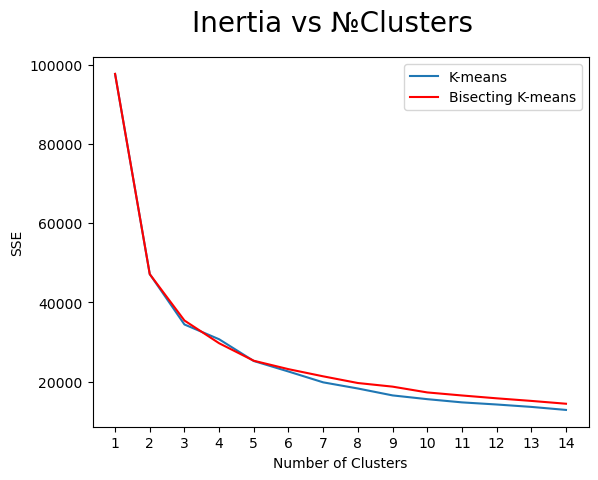

In [15]:
#visualize results
plt.suptitle("Inertia vs №Clusters", fontsize=20)

plt.plot(range(1, 15), sse, label='K-means')
plt.plot(range(1, 15), bisect_sse, label='Bisecting K-means', c="red")
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.legend()
plt.show()

### Evaluate Bisecting K-means Performace

In [16]:
bisect_3_means = BisectingKMeans(n_clusters=3, random_state=42)
bisect_3_means.fit(model_data)
bisect_means_dbs = davies_bouldin_score(model_data, bisect_3_means.labels_)
bisect_means_chs = calinski_harabasz_score(model_data, bisect_3_means.labels_)
print(f'Bisecting K-means with k=3 \nDavies Bouldin Score: {bisect_means_dbs} \nCalinski-Harabasz Score: {bisect_means_chs}\n')

Bisecting K-means with k=3 
Davies Bouldin Score: 0.7879937835088743 
Calinski-Harabasz Score: 396726.5725148199



**! CAUTION!** Evaluating the ```silhouette_score``` is computationally expensive.

In [17]:
print('Bisecting K-means Silhouette Score \nStart: ', datetime.now().isoformat(timespec='seconds'))
bisect_means_silhouette = silhouette_score(model_data, bisect_3_means.labels_)
print('End: ', datetime.now().isoformat(timespec='seconds'), '\nSC: ', bisect_means_silhouette)

Bisecting K-means Silhouette Score 
Start:  2023-11-22T18:58:22
End:  2023-11-22T19:42:00 
SC:  0.5297647189181659


## DBSCAN Clustering using BIRCH
We first need to find the best values for the parameters: we aim for 3<k<9. We start by adjusthing the threshhold. The number of subclusters returned would become k when we run it supervised. 

In [18]:
t_values = [float(value) / 100 for value in range(40, 29, -1)]
for thresh in t_values:
    start_time = datetime.now().isoformat(timespec='seconds')
    print(f'Start: {start_time} threshold: {thresh}')
    brch = Birch(n_clusters=None, threshold=thresh)
    brch.fit(model_data)
    end_time = datetime.now().isoformat(timespec='seconds')
    print(f'End: {end_time}, clusters: {brch.n_clusters}, subclusters: {len(brch.subcluster_centers_)}\n')

Start: 2023-11-22T19:42:00 threshold: 0.4
End: 2023-11-22T19:42:09, clusters: None, subclusters: 2

Start: 2023-11-22T19:42:09 threshold: 0.39
End: 2023-11-22T19:42:19, clusters: None, subclusters: 2

Start: 2023-11-22T19:42:19 threshold: 0.38
End: 2023-11-22T19:42:29, clusters: None, subclusters: 2

Start: 2023-11-22T19:42:29 threshold: 0.37
End: 2023-11-22T19:42:39, clusters: None, subclusters: 2

Start: 2023-11-22T19:42:39 threshold: 0.36
End: 2023-11-22T19:42:48, clusters: None, subclusters: 7

Start: 2023-11-22T19:42:48 threshold: 0.35
End: 2023-11-22T19:42:57, clusters: None, subclusters: 8

Start: 2023-11-22T19:42:57 threshold: 0.34
End: 2023-11-22T19:43:07, clusters: None, subclusters: 9

Start: 2023-11-22T19:43:07 threshold: 0.33
End: 2023-11-22T19:43:16, clusters: None, subclusters: 15

Start: 2023-11-22T19:43:16 threshold: 0.32
End: 2023-11-22T19:43:26, clusters: None, subclusters: 11

Start: 2023-11-22T19:43:26 threshold: 0.31
End: 2023-11-22T19:43:35, clusters: None, subcl

The best ```threshold``` is ```0.36```
## BIRCH Clustering
We can perform clustering using only BIRCH before looking at density clustering.

In [19]:
start_time = datetime.now().isoformat(timespec='seconds')
print(f'Start: {start_time}')
brch_only = Birch(n_clusters=None, threshold=0.36)
brch_only.fit(model_data)
end_time = datetime.now().isoformat(timespec='seconds')
print(f'End: {end_time}, clusters: {np.unique(brch_only.labels_, return_counts=True)}\n')

Start: 2023-11-22T19:43:45
End: 2023-11-22T19:43:54, clusters: (array([0, 1, 2, 3, 4, 5, 6]), array([ 87703, 175175,  10351, 102594,  18450,  10457,  46595],
      dtype=int64))



In [20]:
# Evaluate performance
brch_only_dbs = davies_bouldin_score(model_data, brch_only.labels_)
brch_only_chs = calinski_harabasz_score(model_data, brch_only.labels_)
print(f'BIRCH ONLY \nDavies Bouldin Score: {brch_only_dbs} \nCalinski-Harabsz Score: {brch_only_chs}\n')

BIRCH ONLY 
Davies Bouldin Score: 1.160514304100745 
Calinski-Harabsz Score: 274480.2108759215



**! CAUTION!** Evaluating the ```silhouette_score``` is computationally expensive.

In [21]:
# Evaluate performance with silhouette_score
print('BIRCH Only Silhouette Score \nStart: ', datetime.now().isoformat(timespec='seconds'))
brch_only_silhouette = silhouette_score(model_data, brch_only.labels_)
print('End: ', datetime.now().isoformat(timespec='seconds'), '\nSC: ', brch_only_silhouette)

BIRCH Only Silhouette Score 
Start:  2023-11-22T19:43:54
End:  2023-11-22T20:25:08 
SC:  0.31059723173761006


Next we introduce DBSCAN with the default settings.

In [22]:
dbs = DBSCAN(eps=0.50, min_samples=2)
brch_dbscan = Birch(n_clusters=dbs, threshold=0.36)
brch_dbscan.fit(model_data)
brch_dbscan_davies_bouldin = davies_bouldin_score(model_data, brch_dbscan.labels_)
brch_dbscan_calin_harab = calinski_harabasz_score(model_data, brch_dbscan.labels_)
print(f'BIRCH with DBSCAN with default eps \nDavies Bouldin Score: {brch_dbscan_davies_bouldin} \nCalinski-Harabasz Score: {brch_dbscan_calin_harab}\n')

BIRCH with DBSCAN with default eps 
Davies Bouldin Score: 0.8858288569933866 
Calinski-Harabasz Score: 362764.64210314606



In [23]:
clusters_sizes = np.unique(brch_dbscan.labels_, return_counts=True)
print(f'BIRCH with DBSCAN with default eps:\nNoise: {clusters_sizes[1][0]} Cluster 1: {clusters_sizes[1][1]} Cluster 2: {clusters_sizes[1][2]}')

BIRCH with DBSCAN with default eps:
Noise: 20808 Cluster 1: 134298 Cluster 2: 296219


### Evaluating the _eps_ value

We know that the Calinski-Harabasz Index is generally lower for clusters obtained with DBSCAN, so we focus on Davies Bouldin score. We can see that when ```eps``` is going towards 0.0, the DBS is going up. Samples labeled as ```-1``` are considered noise. Therefore the best value for ```eps``` is ```0.6```.

Since the K-means clustering indicated that there are 3 clusters, we could investigate how the noise is distributed and if it is forming a cluster of it's own. 


In [24]:
# Find the best "eps"

e_values = [float(value) / 100 for value in range(70, 29, -5)]
for e in e_values:
    #Timestamp
    start_time = datetime.now().isoformat(timespec='seconds')
    print(f'Start: {start_time} eps: {e}')
    
    #Run
    dbs = DBSCAN(eps=e, min_samples=2)
    brch_dbscan = Birch(n_clusters=dbs, threshold=0.36)
    brch_dbscan.fit(model_data)
    
    # Evaluation metrics
    brch_dbscan_davies_bouldin = davies_bouldin_score(model_data, brch_dbscan.labels_)
    brch_dbscan_calin_harab = calinski_harabasz_score(model_data, brch_dbscan.labels_)
    end_time = datetime.now().isoformat(timespec='seconds')
    
    print(f'End: {end_time} Clusters: {np.unique(brch_dbscan.labels_)} \nDavies Bouldin Score: {brch_dbscan_davies_bouldin} \nCalinski-Harabasz Score: {brch_dbscan_calin_harab}\n')

Start: 2023-11-22T20:25:18 eps: 0.7
End: 2023-11-22T20:25:28 Clusters: [0 1] 
Davies Bouldin Score: 0.7724428013806582 
Calinski-Harabasz Score: 483751.62101898994

Start: 2023-11-22T20:25:28 eps: 0.65
End: 2023-11-22T20:25:37 Clusters: [0 1] 
Davies Bouldin Score: 0.7724428013806582 
Calinski-Harabasz Score: 483751.62101898994

Start: 2023-11-22T20:25:37 eps: 0.6
End: 2023-11-22T20:25:47 Clusters: [0 1] 
Davies Bouldin Score: 0.7724428013806582 
Calinski-Harabasz Score: 483751.62101898994

Start: 2023-11-22T20:25:47 eps: 0.55
End: 2023-11-22T20:25:57 Clusters: [-1  0  1] 
Davies Bouldin Score: 0.8858288569933866 
Calinski-Harabasz Score: 362764.64210314606

Start: 2023-11-22T20:25:57 eps: 0.5
End: 2023-11-22T20:26:06 Clusters: [-1  0  1] 
Davies Bouldin Score: 0.8858288569933866 
Calinski-Harabasz Score: 362764.64210314606

Start: 2023-11-22T20:26:06 eps: 0.45
End: 2023-11-22T20:26:16 Clusters: [-1  0  1] 
Davies Bouldin Score: 0.9997858748114062 
Calinski-Harabasz Score: 381411.50335

The best ```eps``` is ```0.7``` values over this do not perform any clustering.

## DBSCAN Elbow Method
Another approach for selecting the right value of ```eps``` is measuring the actual distance between points using NearestNeighbours and the elbow method, however when attempted the suggested ```eps``` is ```0.0345``` (as the raw data is very homogenous) which does perform any clustering at all.

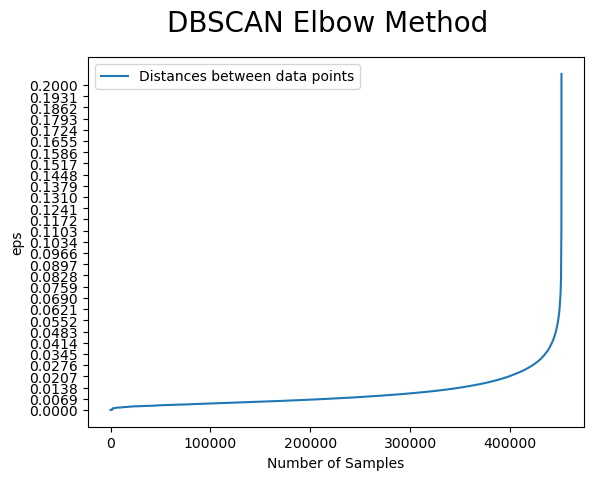

In [25]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(model_data)
distances, indices = nbrs.kneighbors(model_data)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
values = np.linspace(0.0, 0.2, num=30)
plt.suptitle("DBSCAN Elbow Method", fontsize=20)
plt.yticks(values)
plt.ylabel("eps")
plt.xlabel("Number of Samples")
plt.plot(distances, label='Distances between data points')
plt.legend()
plt.show()

Perform DBSCAN Clustering with both ```eps=0.55``` and ```eps=0.6```

In [26]:
#Timestamp
start_time = datetime.now().isoformat(timespec='seconds')
print(f'Start: {start_time}')
    
#Run
dbs_noisy = DBSCAN(eps=0.55, min_samples=2)
dbscan_noisy = Birch(n_clusters=dbs_noisy, threshold=0.36)
dbscan_noisy.fit(model_data)
# Evaluation metrics
dbscan_noisy_dbs = davies_bouldin_score(model_data, brch_dbscan.labels_)
dbscan_noisy_chs = calinski_harabasz_score(model_data, brch_dbscan.labels_)
end_time = datetime.now().isoformat(timespec='seconds')
    
print(f'End: {end_time} \nDBSCAN with Noise clusters: {np.unique(dbscan_noisy.labels_)}, \nDavies Bouldin Score: {dbscan_noisy_dbs}, \nCalinski-Harabasz Score: {dbscan_noisy_chs}\n')

Start: 2023-11-22T20:26:53
End: 2023-11-22T20:27:02 
DBSCAN with Noise clusters: [-1  0  1], 
Davies Bouldin Score: 0.9997858748114062, 
Calinski-Harabasz Score: 381411.5033569091



**! CAUTION!** Evaluating the ```silhouette_score``` is computationally expensive.

In [27]:
print('DBSCAN with Noise Silhouette Score \nStart: ', datetime.now().isoformat(timespec='seconds'))
dbscan_noisy_silhouette = silhouette_score(model_data, dbscan_noisy.labels_)
print('End: ', datetime.now().isoformat(timespec='seconds'), '\nSC: ', dbscan_noisy_silhouette)

DBSCAN with Noise Silhouette Score 
Start:  2023-11-22T20:27:02
End:  2023-11-22T21:11:00 
SC:  0.5288451563463018


In [28]:
#Timestamp
start_time = datetime.now().isoformat(timespec='seconds')
print(f'Start: {start_time}')
    
#Run
dbs_quiet = DBSCAN(eps=0.7, min_samples=2)
dbscan_quiet = Birch(n_clusters=dbs_quiet, threshold=0.36)
dbscan_quiet.fit(model_data)
# Evaluation metrics
dbscan_quiet_dbs = davies_bouldin_score(model_data, dbscan_quiet.labels_)
dbscan_quiet_chs = calinski_harabasz_score(model_data, dbscan_quiet.labels_)
end_time = datetime.now().isoformat(timespec='seconds')
    
print(f'End: {end_time},\nDBSCAN without Noise clusters: {np.unique(dbscan_quiet.labels_)} \nDavies Bouldin Score: {dbscan_quiet_dbs}, \nCalinski-Harabasz Score: {dbscan_quiet_chs}\n')

Start: 2023-11-22T21:11:00
End: 2023-11-22T21:11:09,
DBSCAN without Noise clusters: [0 1] 
Davies Bouldin Score: 0.7724428013806582, 
Calinski-Harabasz Score: 483751.62101898994



**! CAUTION!** Evaluating the ```silhouette_score``` is computationally expensive.

In [29]:
print('DBSCAN without Noise Silhouette Score\nStart: : ', datetime.now().isoformat(timespec='seconds'))
dbscan_quiet_silhouette = silhouette_score(model_data, dbscan_quiet.labels_)
print('End: ', datetime.now().isoformat(timespec='seconds'), '\nSC: ', dbscan_quiet_silhouette)

DBSCAN without Noise Silhouette Score
Start: :  2023-11-22T21:11:09
End:  2023-11-22T21:55:43 
SC:  0.518989100877699


In [30]:
chs_values = np.array([k_means_chs, bisect_means_chs, brch_only_chs, dbscan_noisy_chs, dbscan_quiet_chs])
chs_decimal = chs_values/1000000
chs_decimal

array([0.41480777, 0.39672657, 0.27448021, 0.3814115 , 0.48375162])

In [31]:
k_means_total = sum([k_means_silhouette, 1-k_means_dbs, chs_decimal[0]])/3
bisect_total = sum([bisect_means_silhouette, 1-bisect_means_dbs , chs_decimal[1]])/3
birch_total = sum([brch_only_silhouette, 1-brch_only_dbs, chs_decimal[2]])/3
dbscan_noisy_total = sum([dbscan_noisy_silhouette, 1-dbscan_noisy_dbs, chs_decimal[3]])/3
dbscan_quiet_total = sum([dbscan_quiet_silhouette, 1-dbscan_quiet_dbs, chs_decimal[4]])/3

print(f'Overal Scores:\nK-Means: {k_means_total} \nBisecting K-means: {bisect_total} \nBIRCH: {birch_total}\nDBSCAN with Noise: {dbscan_noisy_total} \nDBSCAN without Noise: {dbscan_quiet_total}')

Overal Scores:
K-Means: 0.37947399801267007 
Bisecting K-means: 0.3794991693080372 
BIRCH: 0.1415210461709288
DBSCAN with Noise: 0.30349026163060155 
DBSCAN without Noise: 0.4100993068386769
